# About Dataset:

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic 
segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. 
The classes are:

1. Building: #3C1098
2. Land (unpaved area): #8429F6
3. Road: #6EC1E4
4. Vegetation: #FEDD3A
5. Water: #E2A929
6. Unlabeled: #9B9B9B

Dataset Link: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery


# Problem Statement:
With the set of images and prior knowledge about the content of the images, we have to find the correct Symantec label for the pixels in the image. Labels are: Buildings, Roads, Land, Water Bodies, Vegetation, and Unlabeled. We need to go through the cycle of segmentation, feature extraction, testing, and validation.

# Importing Libraries

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


# Image Augmentation

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [3]:
root_directory = 'Semantic segmentation dataset/'

In [4]:
patch_size = 256

## For Images... 

In [5]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
     

Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/T

## For their Masks... 

In [6]:
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

## Sanity Check 1 

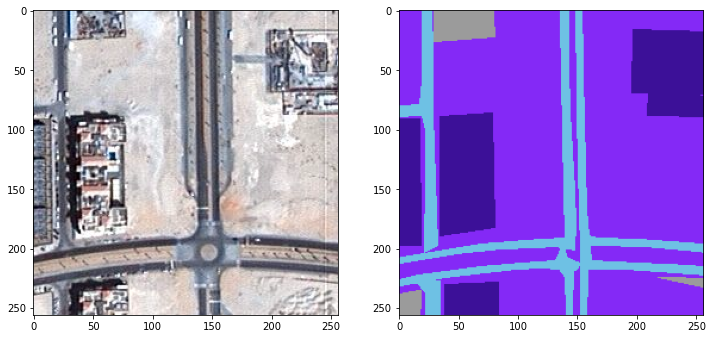

In [8]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

## Converting HEX to RGB values:

In [9]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [10]:
label = single_patch_mask

## Replacing RGB to integer values to be used as labels: 

In [11]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [13]:
print("Unique labels in label dataset are: ", np.unique(labels))


Unique labels in label dataset are:  [0 1 2 3 4 5]


## Sanity Check 2

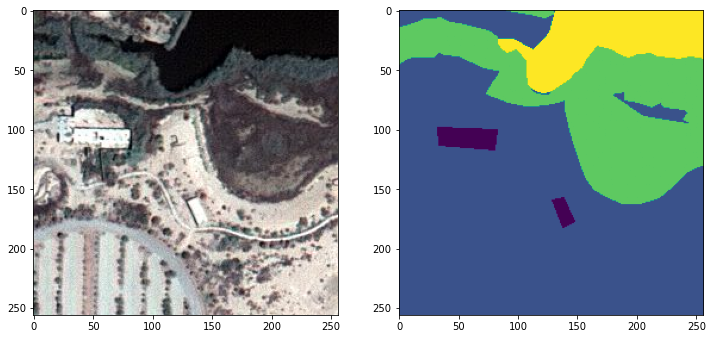

In [14]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Model Building: Multi Unet Model

## Train Test Split: 

In [15]:
#To convert our split data into Training and Test dataset in 80:20 ratio
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## Model Parameters: 

In [16]:
#Parameters for model
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

## Importing Libraries: 

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

## Function to calculate Jacard Coefficient:

In [19]:
#The Jaccard similarity index compares members for two sets to see which members are shared and which are distinct.
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## Function to Build the Unet Model:

In [20]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [21]:
metrics=['accuracy', jacard_coef]

# To call the above function
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


## Model Building using Adam Optimizer

In [22]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [23]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 307s 5s/step - loss: 0.9986 - accuracy: 0.5347 - jacard_coef: 0.2556 - val_loss: 0.9831 - val_accuracy: 0.6618 - val_jacard_coef: 0.3295
Epoch 2/100
66/66 [==============================] - 301s 5s/step - loss: 0.9704 - accuracy: 0.6733 - jacard_coef: 0.3969 - val_loss: 0.9613 - val_accuracy: 0.7192 - val_jacard_coef: 0.4166
Epoch 3/100
66/66 [==============================] - 299s 5s/step - loss: 0.9537 - accuracy: 0.7314 - jacard_coef: 0.4713 - val_loss: 0.9567 - val_accuracy: 0.7182 - val_jacard_coef: 0.4762
Epoch 4/100
66/66 [==============================] - 305s 5s/step - loss: 0.9463 - accuracy: 0.7483 - jacard_coef: 0.5099 - val_loss: 0.9504 - val_accuracy: 0.7375 - val_jacard_coef: 0.5048
Epoch 5/100
66/66 [==============================] - 289s 4s/step - loss: 0.9401 - accuracy: 0.7691 - jacard_coef: 0.5436 - val_loss: 0.9559 - val_accuracy: 0.7330 - val_jacard_coef: 0.5242
Epoch 6/100
66/66 [==============================]

Epoch 44/100
66/66 [==============================] - 287s 4s/step - loss: 0.8986 - accuracy: 0.8622 - jacard_coef: 0.7170 - val_loss: 0.9129 - val_accuracy: 0.8348 - val_jacard_coef: 0.6718
Epoch 45/100
66/66 [==============================] - 288s 4s/step - loss: 0.8985 - accuracy: 0.8638 - jacard_coef: 0.7179 - val_loss: 0.9083 - val_accuracy: 0.8528 - val_jacard_coef: 0.6998
Epoch 46/100
66/66 [==============================] - 328s 5s/step - loss: 0.8999 - accuracy: 0.8590 - jacard_coef: 0.7102 - val_loss: 0.9122 - val_accuracy: 0.8414 - val_jacard_coef: 0.6834
Epoch 47/100
66/66 [==============================] - 288s 4s/step - loss: 0.8981 - accuracy: 0.8641 - jacard_coef: 0.7192 - val_loss: 0.9070 - val_accuracy: 0.8541 - val_jacard_coef: 0.6983
Epoch 48/100
66/66 [==============================] - 288s 4s/step - loss: 0.8962 - accuracy: 0.8679 - jacard_coef: 0.7258 - val_loss: 0.9087 - val_accuracy: 0.8484 - val_jacard_coef: 0.6956
Epoch 49/100
66/66 [=========================

Epoch 87/100
66/66 [==============================] - 289s 4s/step - loss: 0.8783 - accuracy: 0.9079 - jacard_coef: 0.7999 - val_loss: 0.9021 - val_accuracy: 0.8688 - val_jacard_coef: 0.7365
Epoch 88/100
66/66 [==============================] - 288s 4s/step - loss: 0.8781 - accuracy: 0.9081 - jacard_coef: 0.8005 - val_loss: 0.9045 - val_accuracy: 0.8648 - val_jacard_coef: 0.7346
Epoch 89/100
66/66 [==============================] - 289s 4s/step - loss: 0.8777 - accuracy: 0.9091 - jacard_coef: 0.8028 - val_loss: 0.9038 - val_accuracy: 0.8677 - val_jacard_coef: 0.7389
Epoch 90/100
66/66 [==============================] - 288s 4s/step - loss: 0.8803 - accuracy: 0.9026 - jacard_coef: 0.7900 - val_loss: 0.9036 - val_accuracy: 0.8631 - val_jacard_coef: 0.7239
Epoch 91/100
66/66 [==============================] - 288s 4s/step - loss: 0.8860 - accuracy: 0.8888 - jacard_coef: 0.7638 - val_loss: 0.9042 - val_accuracy: 0.8623 - val_jacard_coef: 0.7210
Epoch 92/100
66/66 [=========================

## Model Buliding using Adamax Optimizer

In [23]:
model2 = get_model()
model2.compile(optimizer='adamax', loss=total_loss, metrics=metrics)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [25]:
history2 = model2.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 299s 5s/step - loss: 0.9921 - accuracy: 0.5788 - jacard_coef: 0.3126 - val_loss: 0.9895 - val_accuracy: 0.6337 - val_jacard_coef: 0.3454
Epoch 2/100
66/66 [==============================] - 298s 5s/step - loss: 0.9852 - accuracy: 0.6214 - jacard_coef: 0.3440 - val_loss: 0.9787 - val_accuracy: 0.7051 - val_jacard_coef: 0.3580
Epoch 3/100
66/66 [==============================] - 289s 4s/step - loss: 0.9693 - accuracy: 0.6767 - jacard_coef: 0.4035 - val_loss: 0.9595 - val_accuracy: 0.7437 - val_jacard_coef: 0.4477
Epoch 4/100
66/66 [==============================] - 288s 4s/step - loss: 0.9580 - accuracy: 0.7157 - jacard_coef: 0.4535 - val_loss: 0.9578 - val_accuracy: 0.7245 - val_jacard_coef: 0.4437
Epoch 5/100
66/66 [==============================] - 289s 4s/step - loss: 0.9511 - accuracy: 0.7392 - jacard_coef: 0.4836 - val_loss: 0.9552 - val_accuracy: 0.7256 - val_jacard_coef: 0.4599
Epoch 6/100
66/66 [==============================]

Epoch 44/100
66/66 [==============================] - 291s 4s/step - loss: 0.9018 - accuracy: 0.8681 - jacard_coef: 0.7152 - val_loss: 0.9221 - val_accuracy: 0.8310 - val_jacard_coef: 0.6717
Epoch 45/100
66/66 [==============================] - 291s 4s/step - loss: 0.9017 - accuracy: 0.8670 - jacard_coef: 0.7162 - val_loss: 0.9244 - val_accuracy: 0.8216 - val_jacard_coef: 0.6555
Epoch 46/100
66/66 [==============================] - 292s 4s/step - loss: 0.9011 - accuracy: 0.8674 - jacard_coef: 0.7184 - val_loss: 0.9160 - val_accuracy: 0.8407 - val_jacard_coef: 0.6800
Epoch 47/100
66/66 [==============================] - 291s 4s/step - loss: 0.8995 - accuracy: 0.8709 - jacard_coef: 0.7266 - val_loss: 0.9144 - val_accuracy: 0.8426 - val_jacard_coef: 0.6877
Epoch 48/100
66/66 [==============================] - 291s 4s/step - loss: 0.8993 - accuracy: 0.8686 - jacard_coef: 0.7251 - val_loss: 0.9136 - val_accuracy: 0.8404 - val_jacard_coef: 0.6819
Epoch 49/100
66/66 [=========================

Epoch 87/100
66/66 [==============================] - 291s 4s/step - loss: 0.8775 - accuracy: 0.9045 - jacard_coef: 0.7933 - val_loss: 0.9138 - val_accuracy: 0.8467 - val_jacard_coef: 0.7071
Epoch 88/100
66/66 [==============================] - 291s 4s/step - loss: 0.8777 - accuracy: 0.9040 - jacard_coef: 0.7920 - val_loss: 0.9176 - val_accuracy: 0.8421 - val_jacard_coef: 0.7016
Epoch 89/100
66/66 [==============================] - 291s 4s/step - loss: 0.8772 - accuracy: 0.9055 - jacard_coef: 0.7951 - val_loss: 0.9151 - val_accuracy: 0.8404 - val_jacard_coef: 0.6977
Epoch 90/100
66/66 [==============================] - 291s 4s/step - loss: 0.8774 - accuracy: 0.9052 - jacard_coef: 0.7950 - val_loss: 0.9168 - val_accuracy: 0.8393 - val_jacard_coef: 0.6963
Epoch 91/100
66/66 [==============================] - 291s 4s/step - loss: 0.8782 - accuracy: 0.9031 - jacard_coef: 0.7910 - val_loss: 0.9198 - val_accuracy: 0.8296 - val_jacard_coef: 0.6808
Epoch 92/100
66/66 [=========================

## Model Building using RMSprop Optimizer

In [24]:
model3 = get_model()
model3.compile(optimizer='rmsprop', loss=total_loss, metrics=metrics)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

 conv2d_52 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_10[0][0]']         
                                )                                                                 
                                                                                                  
 dropout_25 (Dropout)           (None, 128, 128, 32  0           ['conv2d_52[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_53 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_25[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 256, 256, 16  2064       ['conv2d_53[0][0]']              
 nspose)  

In [25]:
history3 = model3.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 303s 5s/step - loss: 0.9905 - accuracy: 0.5866 - jacard_coef: 0.3046 - val_loss: 0.9788 - val_accuracy: 0.6637 - val_jacard_coef: 0.4360
Epoch 2/100
66/66 [==============================] - 293s 4s/step - loss: 0.9662 - accuracy: 0.6895 - jacard_coef: 0.4246 - val_loss: 0.9550 - val_accuracy: 0.7361 - val_jacard_coef: 0.4710
Epoch 3/100
66/66 [==============================] - 292s 4s/step - loss: 0.9552 - accuracy: 0.7219 - jacard_coef: 0.4740 - val_loss: 0.9579 - val_accuracy: 0.7256 - val_jacard_coef: 0.5012
Epoch 4/100
66/66 [==============================] - 291s 4s/step - loss: 0.9488 - accuracy: 0.7426 - jacard_coef: 0.5066 - val_loss: 0.9484 - val_accuracy: 0.7459 - val_jacard_coef: 0.5215
Epoch 5/100
66/66 [==============================] - 294s 4s/step - loss: 0.9440 - accuracy: 0.7576 - jacard_coef: 0.5330 - val_loss: 0.9519 - val_accuracy: 0.7351 - val_jacard_coef: 0.5228
Epoch 6/100
66/66 [==============================]

Epoch 44/100
66/66 [==============================] - 291s 4s/step - loss: 0.8937 - accuracy: 0.8757 - jacard_coef: 0.7400 - val_loss: 0.9126 - val_accuracy: 0.8510 - val_jacard_coef: 0.7091
Epoch 45/100
66/66 [==============================] - 291s 4s/step - loss: 0.8921 - accuracy: 0.8786 - jacard_coef: 0.7461 - val_loss: 0.9168 - val_accuracy: 0.8399 - val_jacard_coef: 0.6929
Epoch 46/100
66/66 [==============================] - 292s 4s/step - loss: 0.8918 - accuracy: 0.8809 - jacard_coef: 0.7495 - val_loss: 0.9106 - val_accuracy: 0.8547 - val_jacard_coef: 0.7126
Epoch 47/100
66/66 [==============================] - 292s 4s/step - loss: 0.8919 - accuracy: 0.8796 - jacard_coef: 0.7461 - val_loss: 0.9088 - val_accuracy: 0.8568 - val_jacard_coef: 0.7176
Epoch 48/100
66/66 [==============================] - 291s 4s/step - loss: 0.8901 - accuracy: 0.8833 - jacard_coef: 0.7543 - val_loss: 0.9114 - val_accuracy: 0.8523 - val_jacard_coef: 0.7122
Epoch 49/100
66/66 [=========================

Epoch 87/100
66/66 [==============================] - 289s 4s/step - loss: 0.8775 - accuracy: 0.9107 - jacard_coef: 0.8061 - val_loss: 0.9091 - val_accuracy: 0.8646 - val_jacard_coef: 0.7375
Epoch 88/100
66/66 [==============================] - 289s 4s/step - loss: 0.8748 - accuracy: 0.9160 - jacard_coef: 0.8160 - val_loss: 0.9079 - val_accuracy: 0.8666 - val_jacard_coef: 0.7412
Epoch 89/100
66/66 [==============================] - 289s 4s/step - loss: 0.8749 - accuracy: 0.9158 - jacard_coef: 0.8160 - val_loss: 0.9085 - val_accuracy: 0.8667 - val_jacard_coef: 0.7412
Epoch 90/100
66/66 [==============================] - 289s 4s/step - loss: 0.8749 - accuracy: 0.9141 - jacard_coef: 0.8128 - val_loss: 0.9041 - val_accuracy: 0.8728 - val_jacard_coef: 0.7511
Epoch 91/100
66/66 [==============================] - 289s 4s/step - loss: 0.8740 - accuracy: 0.9178 - jacard_coef: 0.8195 - val_loss: 0.9107 - val_accuracy: 0.8621 - val_jacard_coef: 0.7327
Epoch 92/100
66/66 [=========================

# Comparing results of all 3 Models

## Ploting the training and validation accuracy and loss at each epoch 

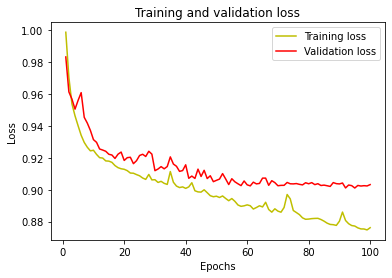

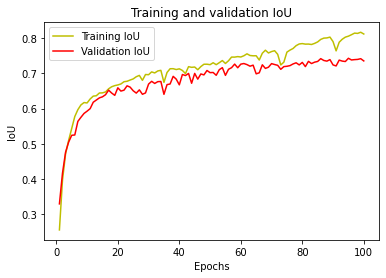

In [24]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


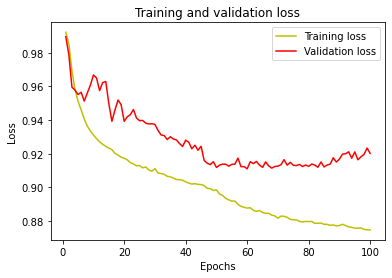

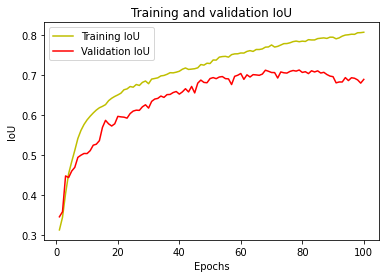

In [26]:
#plot the training and validation accuracy and loss at each epoch
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


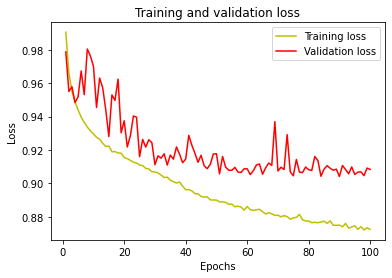

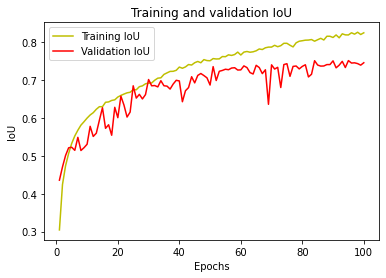

In [35]:
#plot the training and validation accuracy and loss at each epoch
history = history3
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

## IOU 

In [25]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 [==============================] - 12s 1s/step
Mean IoU = 0.61098385


In [27]:
#IOU
y_pred=model2.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 [==============================] - 12s 1s/step
Mean IoU = 0.5555609


In [36]:
#IOU
y_pred=model3.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 [==============================] - 13s 1s/step
Mean IoU = 0.61034524


## Predicting Images 

1/1 [==============================] - 0s 73ms/step


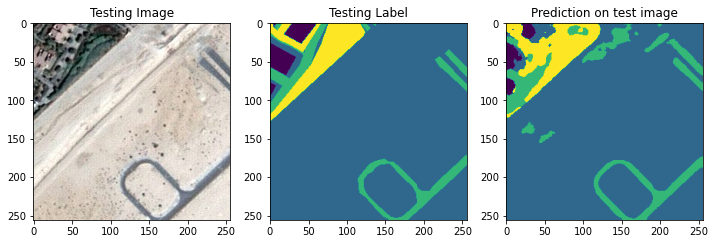

In [41]:
#Predicting few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 0s 67ms/step


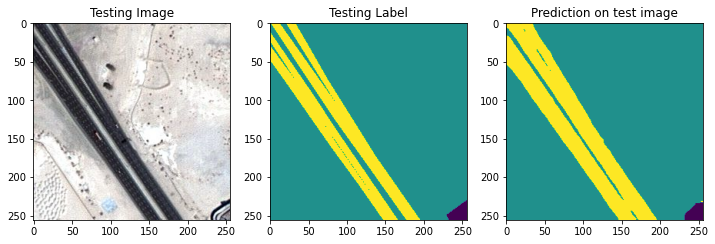

In [47]:
#Predicting few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model2.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 0s 72ms/step


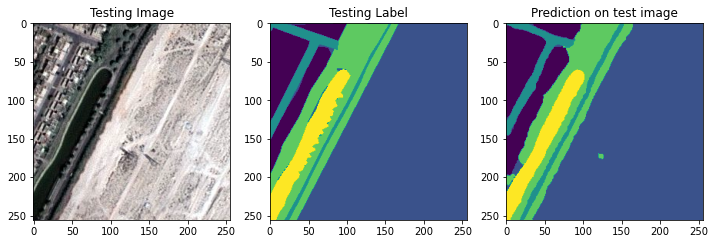

In [50]:
#Predicting few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model3.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()